In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Dataset Preparation

In [ ]:
!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

Dataset URL: https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.54G/2.55G [00:16<00:00, 188MB/s]
100% 2.55G/2.55G [00:16<00:00, 164MB/s]


In [ ]:
%%capture
!unzip sentinel12-image-pairs-segregated-by-terrain.zip
!rm -rf sentinel12-image-pairs-segregated-by-terrain.zip

In [ ]:
import os
import shutil
opt = []
sar = []
root_dir = './v_2'
for dir in os.listdir(root_dir):
  path = os.path.join(root_dir, dir)
  s1, s2  = os.listdir(path)
  if s1 == 's2':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s2, file))
  if s1 == 's1':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s2, file))
opt = sorted(opt)
sar = sorted(sar)
print(len(opt), len(sar))


16000 16000


# **Denoising Method-2 (Using FFDNet)**

- Trying to remove speckle noise using FFDNet



In [ ]:
# Libraries import

from google.colab import drive
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from skimage.metrics import structural_similarity as ssim
import cv2

In [ ]:
# train_list =  sar[:8000]
# test_list = sar[8000:]

In [ ]:
# Storing the datasets as np arrays to be used in future

train_list = []
test_list = []

for path in sar[:8000]:
  img = Image.open(path)
  img = img.convert('L')
  train_list.append(np.array(img))

for path in sar[8000:10000]:
  img = Image.open(path)
  img = img.convert('L')
  test_list.append(np.array(img))

In [ ]:
total_size = sum(arr.size for arr in test_list)  # Iterate through each array (arr) in test_list and sum their sizes
print(total_size)  # Print the total size

65536000


In [ ]:
# Patching the images for training set with img_size = 128

img_size=128

X_train=np.zeros((1,img_size,img_size))

for train_image in train_list:

  for i in range(int(train_image.shape[0]/img_size)):
    for j in range(int(train_image.shape[1]/img_size)):
      im_to_add=np.expand_dims(train_image[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size],axis=0)
      X_train=np.concatenate((X_train,im_to_add),axis=0)

X_train=X_train[1:,:,:]

print("Shape of the training set is: ",X_train.shape)

Shape of the training set is:  (2000, 128, 128)


In [ ]:
# Patching the images for training set with img_size = 256

img_size=256

X_test=np.zeros((1,img_size,img_size))

for test_image in test_list:

  for i in range(int(test_image.shape[0]/img_size)):
    for j in range(int(test_image.shape[1]/img_size)):
      # print(test_image.shape[0])
      im_to_add=np.expand_dims(test_image[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size],axis=0)
      X_test=np.concatenate((X_test,im_to_add),axis=0)

X_test=X_test[1:,:,:]

print("Shape of the test set is: ",X_test.shape)

Shape of the test set is:  (4000, 128, 128)


In [ ]:
# This snippet is to be used only if we don't use image patching above

# import numpy as np
# X_train = np.stack(train_list, axis=0)
# print("Shape of the train set is: ",X_train.shape)

# X_test = np.stack(test_list, axis=0)
# print("Shape of the test set is: ",X_test.shape)

Shape of the train set is:  (8000, 256, 256)


In [ ]:
# For noised images (SAR)

"""
Normalization
1- Function to normalize the data
2- Application to the training and testing sets
"""

def normalize_SAR(dim,log=False):

  # Normalization parameters
  M = 10.089038980848645
  m = -1.429329123112601

  if log:
    dim = ((np.log(dim)-m)*255 / (M - m))
  else:
    dim = (dim-np.exp(m))*255 / (np.exp(M) - np.exp(m))

  return dim

## Training set
for i in range(X_train.shape[0]):
  X_train[i]=normalize_SAR(X_train[i])

## Testing set
for i in range(X_test.shape[0]):
  X_test[i]=normalize_SAR(X_test[i])

In [ ]:
# For coloured (Optical) images

## Training set
for i in range(X_train_opt.shape[0]):
  X_train_opt[i]=normalize_SAR(X_train_opt[i])

## Testing set
for i in range(X_test_opt.shape[0]):
  X_test_opt[i]=normalize_SAR(X_test_opt[i])

In [ ]:
import numpy as np

# Convert lists to NumPy arrays if not already
X_test = np.array(X_test)
X_test_opt = np.array(X_test_opt)

# Create tuples for testing couples
X_test_couples = np.stack([X_test_opt, X_test], axis=0)

print("Shape of the testing couples:", X_test_couples.shape)

Shape of the testing couples: (2, 4000, 128, 128)


True image


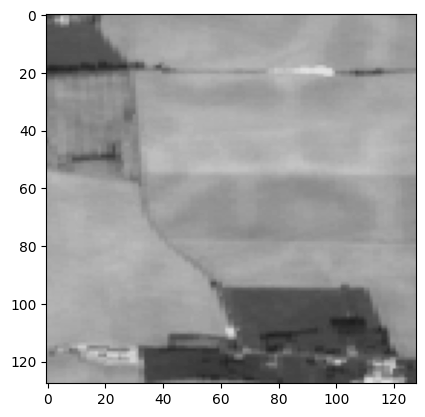

Noisy image


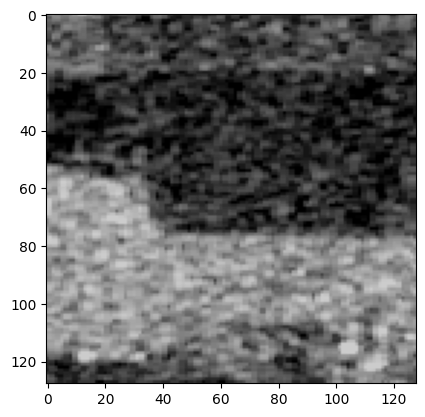

True image


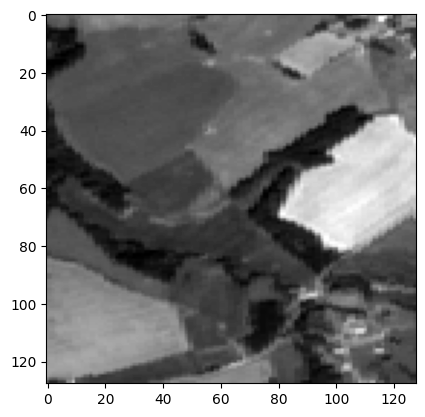

Noisy image


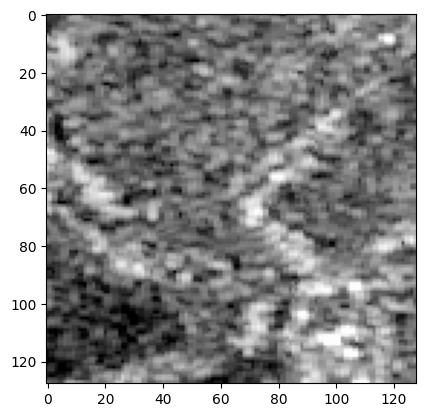

True image


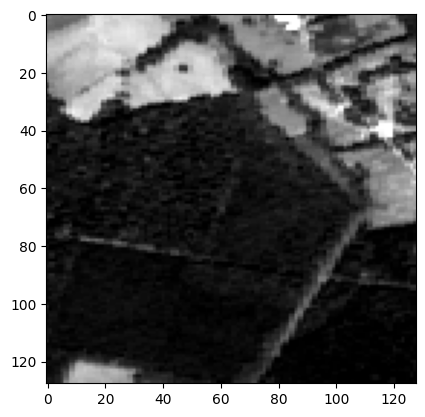

Noisy image


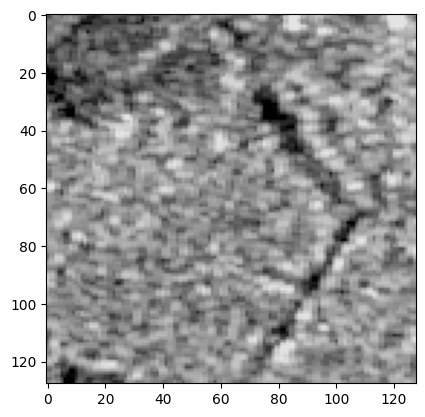

In [ ]:
# Plotting true images vs noisy images

def plot_SAR(np_array,log=False):

  # Normalization parameters
  M = 10.089038980848645
  m = -1.429329123112601
  dim = np_array
  dim = np.squeeze(dim)
  threshold=np.mean(dim) + 3*np.std(dim)
  dim = np.clip(dim,0,threshold)
  dim = dim/threshold*255
  dim = Image.fromarray(dim.astype('float64')).convert('L')
  plt.imshow(dim,cmap="gray",vmin=0,vmax=255)
  plt.show()

for i in [1,12,25]:
  print("True image")
  plot_SAR(X_train_couples[0,i,:,:])
  print("Noisy image")
  plot_SAR(X_train_couples[1,i,:,:])

In [ ]:
# Saving the denoised and noisy images

def save_SAR(np_array,name,add_speckle=False):

  # Normalization parameters
  M = 10.089038980848645
  m = -1.429329123112601

  # Thres + log
  dim = np_array
  dim = np.squeeze(dim)
  threshold=np.mean(dim) + 3*np.std(dim)
  dim = np.clip(dim,0,threshold)
  dim = dim/threshold*255
  # if add_speckle:
    # dim=injectspeckle_amplitude(dim,L=1,sing_im=True)
  dim = Image.fromarray(dim.astype('float64')).convert('L')
  dim.save(name)

# Training set (denoised images)
! rm -rf trainsets
! mkdir trainsets
! mkdir trainsets/trainH
for i in range(X_train_couples.shape[1]):
  name="trainsets/trainH/im"+str(i)+".bmp"
  save_SAR(X_train_couples[0,i,:,:],name=name)

# Testing set (noisy images)
! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68
for i in range(X_test_couples.shape[1]):
  name="testsets/bsd68/im"+str(i)+".bmp"
  save_SAR(X_test_couples[0,i,:,:],name=name)

In [ ]:
# Clear the working space
! rm -rf MVA_Remote
! rm -rf data
! rm -rf model_zoo
! rm -rf models
! rm -rf options
! rm -rf results
! rm -rf utils
! rm -rf main_train_ffdnet.py
! rm -rf main_test_ffdnet.py
! rm -rf denoising

# Git clone
! git clone https://github.com/MathieuRita/MVA_Remote.git

# Move the useful files in content
! mv "./MVA_Remote/data" "./data"
! mv "./MVA_Remote/model_zoo" "./model_zoo"
! mv "./MVA_Remote/models" "./models"
! mv "./MVA_Remote/options" "./options"
! mv "./MVA_Remote/results" "./results"
! mv "./MVA_Remote/utils" "./utils"
! mv "./MVA_Remote/main_train_ffdnet.py" "./main_train_ffdnet.py"
! mv "./MVA_Remote/main_test_ffdnet.py" "./main_test_ffdnet.py"
! mv "./MVA_Remote/main_test_ffdnet_LM.py" "./main_test_ffdnet_LM.py"
! mv "./MVA_Remote/main_test_ffdnet_oracle.py" "./main_test_ffdnet_oracle.py"
! rm -rf MVA_Remote

# Create useful directories for training procedure
! mkdir "denoising"
! mkdir "denoising/ffdnet"
! mkdir "denoising/ffdnet/images"
! mkdir "denoising/ffdnet/models"
! mkdir "denoising/ffdnet/options"

Cloning into 'MVA_Remote'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 438 (delta 6), reused 5 (delta 2), pack-reused 420 (from 1)
Receiving objects: 100% (438/438), 161.58 MiB | 36.60 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
# For the training procedure, add clear testing images

! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68
for i in range(X_test_couples.shape[1]):
  name="testsets/bsd68/im"+str(i)+".bmp"
  save_SAR(X_test_couples[1,i,:,:],name=name)

# Run the training procedure
! python -m main_train_ffdnet

export CUDA_VISIBLE_DEVICES=0
LogHandlers setup!
24-11-18 07:35:34.756 :   task: ffdnet
  model: plain2
  gpu_ids: [0]
  scale: 1
  n_channels: 1
  sigma: [0, 75]
  sigma_test: 25
  merge_bn: False
  merge_bn_startpoint: 400000
  path:[
    root: denoising
    pretrained_netG: None
    task: denoising/ffdnet
    log: denoising/ffdnet
    options: denoising/ffdnet/options
    models: denoising/ffdnet/models
    images: denoising/ffdnet/images
  ]
  datasets:[
    train:[
      name: train_dataset
      dataset_type: ffdnet
      dataroot_H: trainsets/trainH
      dataroot_L: None
      H_size: 64
      dataloader_shuffle: True
      dataloader_num_workers: 8
      dataloader_batch_size: 64
      phase: train
      scale: 1
      n_channels: 1
    ]
    test:[
      name: test_dataset
      dataset_type: ffdnet
      dataroot_H: testsets/bsd68
      dataroot_L: None
      phase: test
      scale: 1
      n_channels: 1
    ]
  ]
  netG:[
    net_type: ffdnet
    in_nc: 1
    out_nc: 1
   

In [ ]:
# Creating the testing set with noisy images

! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68
for i in range(X_test_couples.shape[1]):
  name="testsets/bsd68/im"+str(i)+".bmp"
  save_SAR(X_test_couples[1,i,:,:],name=name,add_speckle=True)

print("\n Denoised with the uniform noise map method \n")
# Denoising with uniform noise map
! python -m main_test_ffdnet

# print("\n Denoised with the LM method \n")
# # Denoising with Local Means
# ! python -m main_test_ffdnet_LM

# print("\n Denoised with the Oracle method \n")
# # Denoising with the Oracle Method
# ! python -m main_test_ffdnet_oracle


 Denoised with the uniform noise map method 

LogHandlers setup!
/content/main_test_ffdnet.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch

In [ ]:
def plot_results(model_name,ind_im=0,real_name="no"):

  """
  Function that plots the results (noisy, true and denooised images)
  """

  if real_name=="no":
    print("\n Image "+str(ind_im)+" \n")
    print("Noisy")
    plot_SAR(X_test_couples[1,ind_im,:,:])
    print("True")
    plot_SAR(X_test_couples[0,ind_im,:,:])
    print("denoised")
    im = Image.open("results/bsd68_"+model_name+"/im"+str(ind_im)+".bmp")
    plt.imshow(np.array(im).astype(int),"gray",vmin=0,vmax=255)
    plt.show()
  else:
    print("\n"+ real_name+" \n")
    print("Noisy")
    if real_name!="terrasar":
      im = Image.open("testsets/bsd68/"+real_name+".bmp")
    else:
      im = Image.open("testsets/bsd68/"+real_name+".jpg")
    plt.imshow(np.array(im).astype(int),"gray",vmin=0,vmax=255)
    plt.show()

    print("Denoised")
    if real_name!="terrasar":
      im = Image.open("results/bsd68_"+model_name+"/"+real_name+".bmp")
    else:
      im = Image.open("results/bsd68_"+model_name+"/"+real_name+".jpg")

    plt.imshow(np.array(im).astype(int),"gray",vmin=0,vmax=255)
    plt.show()


 Image 0 

Noisy


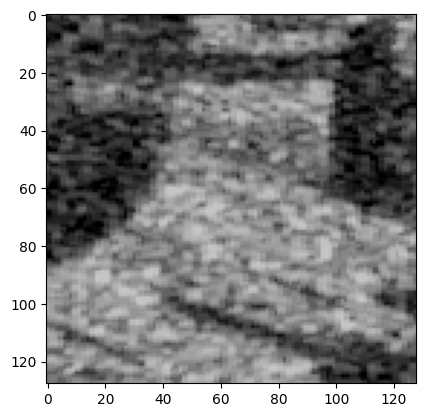

True


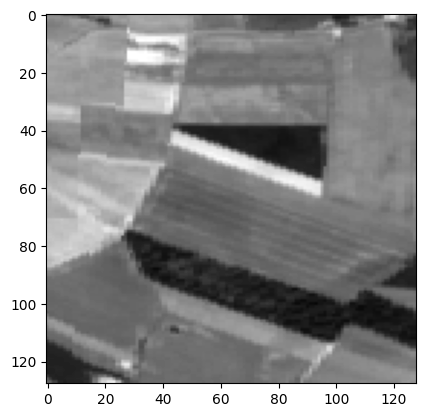

denoised


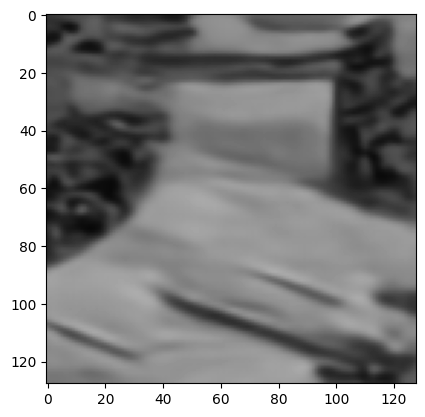


 Image 1 

Noisy


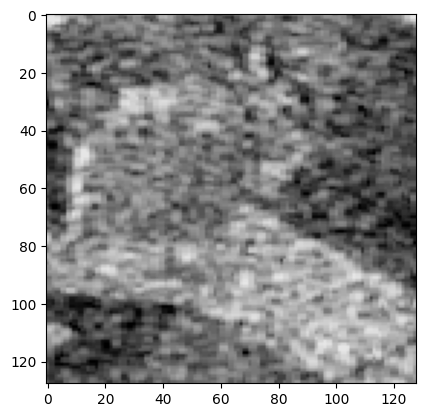

True


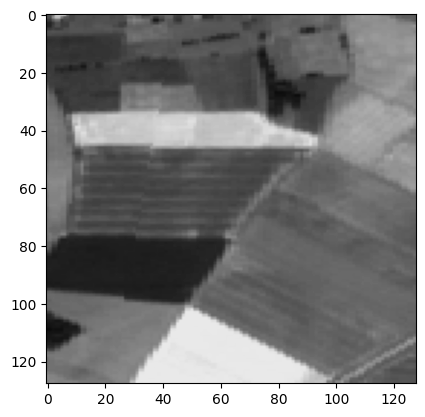

denoised


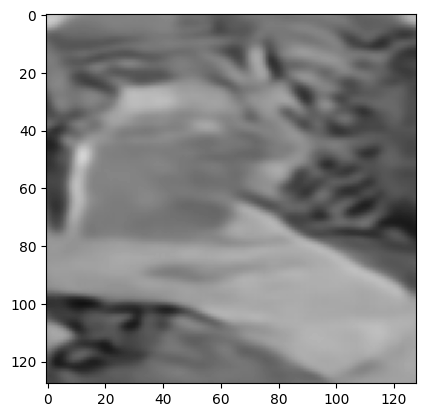


 Image 2 

Noisy


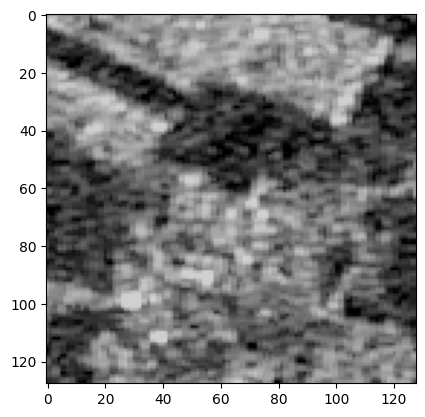

True


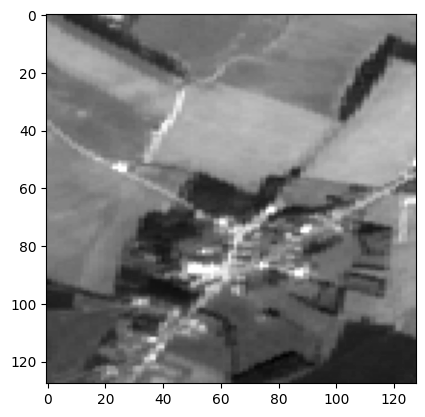

denoised


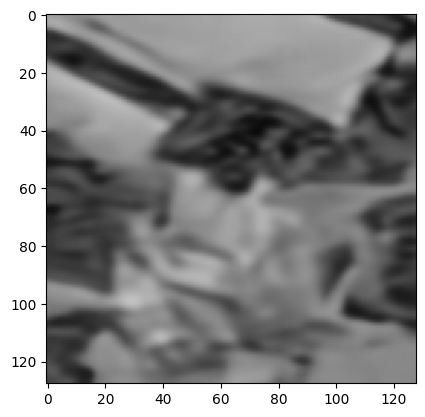


 Image 3 

Noisy


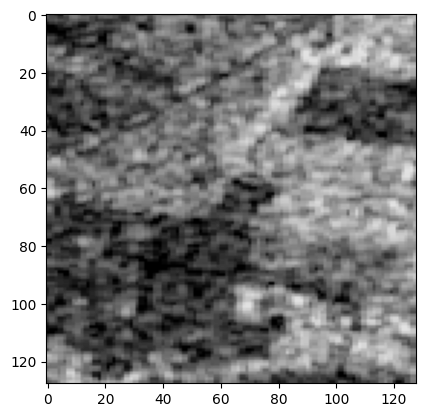

True


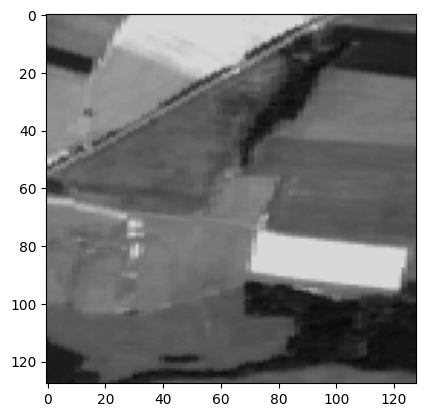

denoised


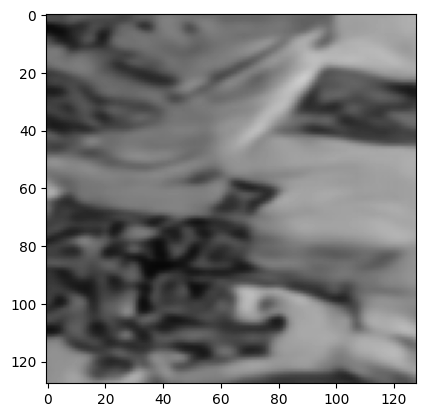


 Image 4 

Noisy


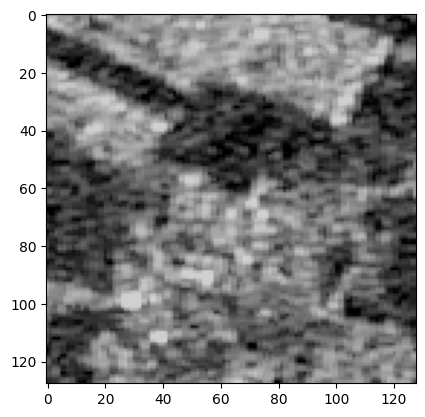

True


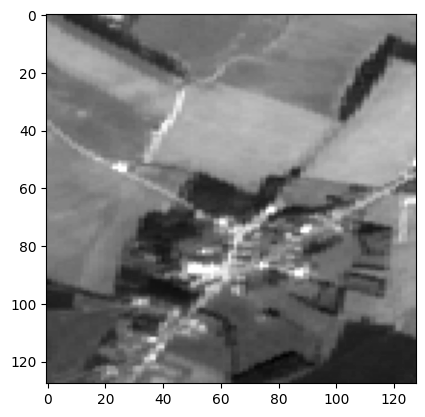

denoised


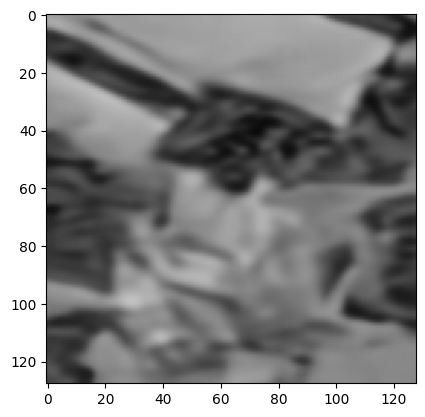


 Image 5 

Noisy


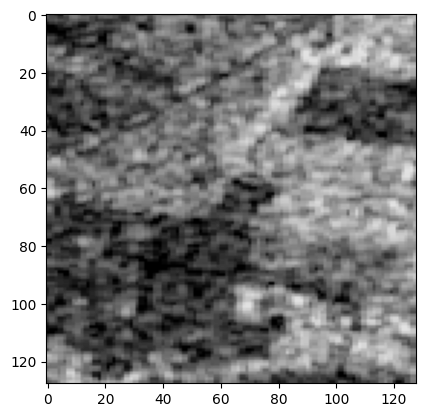

True


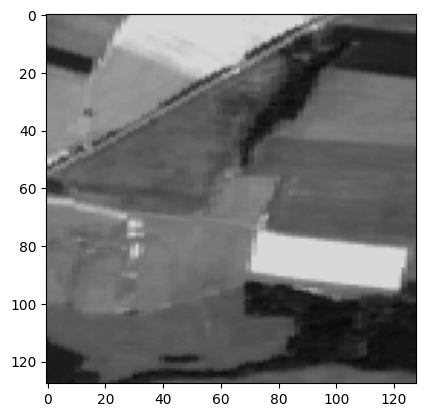

denoised


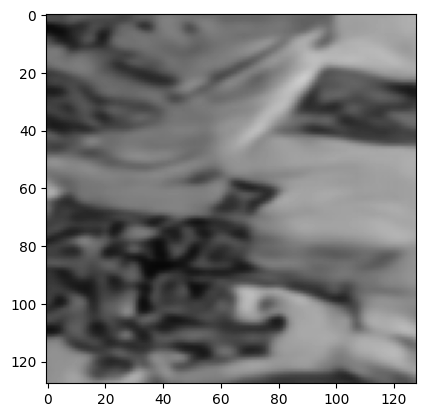


 Image 6 

Noisy


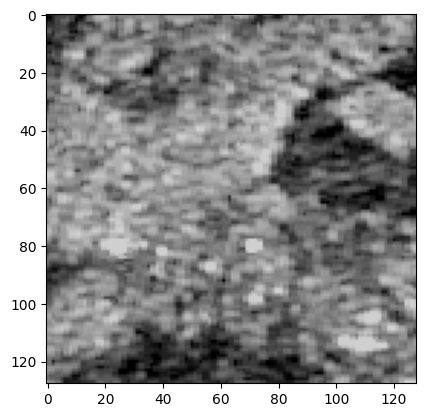

True


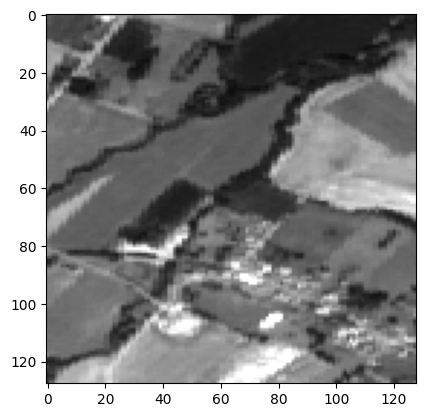

denoised


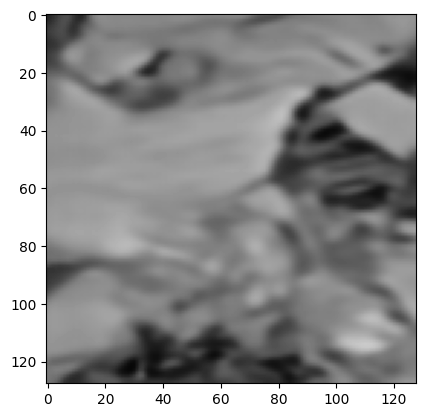

In [ ]:
model_name="loss_L1_view_L1"

for ind_im in range(7):
  plot_results(model_name,ind_im)

## The code below is the original code previously used

# **Denoising The SAR Images**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from skimage import util
import numpy as np
from PIL import Image

class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(1, n_channels, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, 1, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)



In [ ]:
# Dataset Class for Noisy/Clean Image Pairs
class SARImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.sar = clean_images[0]
        self.opt = clean_images[1]
        self.transform = transform

    def __len__(self):
        return len(self.sar)

    def __getitem__(self, idx):
        sar_img = self.sar[idx]
        opt_img = self.opt[idx]
        noisy_img = np.array(Image.open(sar_img).convert('L'))
        img = np.array(Image.open(opt_img).convert('L'))
        if self.transform:
            img = self.transform(img)
            noisy_img = self.transform(noisy_img)
        return noisy_img, img

# Load and preprocess data
images = [sar[:10000], opt[:10000]]
dataset = SARImageDataset(images, transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)


In [ ]:
from tqdm import tqdm

# Training the DnCNN Model
model = DnCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, dataloader, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch") as pbar:
            epoch_loss = 0
            for noisy_imgs, clean_imgs in dataloader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                optimizer.zero_grad()
                denoised_imgs = model(noisy_imgs)
                loss = criterion(denoised_imgs, clean_imgs)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                # Update progress bar
                pbar.set_postfix(loss=f"{epoch_loss/(pbar.n+1):.4f}")
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

train(model, train_loader)


Epoch 1/15 (Training): 100%|██████████| 1000/1000 [08:31<00:00,  1.95batch/s, loss=0.0483]


Epoch [1/15], Loss: 0.0483


Epoch 1/15 (Training): 100%|██████████| 1000/1000 [08:31<00:00,  1.95batch/s, loss=0.0483]


Epoch [1/15], Loss: 0.0483


Epoch 2/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0428]


Epoch [2/15], Loss: 0.0428


Epoch 2/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0428]


Epoch [2/15], Loss: 0.0428


Epoch 3/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0411]


Epoch [3/15], Loss: 0.0411


Epoch 3/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0411]


Epoch [3/15], Loss: 0.0411


Epoch 4/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0402]


Epoch [4/15], Loss: 0.0402


Epoch 4/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0402]


Epoch [4/15], Loss: 0.0402


Epoch 5/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0381]


Epoch [5/15], Loss: 0.0381


Epoch 5/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0381]


Epoch [5/15], Loss: 0.0381


Epoch 6/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0362]


Epoch [6/15], Loss: 0.0362


Epoch 6/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0362]


Epoch [6/15], Loss: 0.0362


Epoch 7/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0344]


Epoch [7/15], Loss: 0.0344


Epoch 7/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0344]


Epoch [7/15], Loss: 0.0344


Epoch 8/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0328]


Epoch [8/15], Loss: 0.0328


Epoch 8/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0328]


Epoch [8/15], Loss: 0.0328


Epoch 9/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0311]


Epoch [9/15], Loss: 0.0311


Epoch 9/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0311]


Epoch [9/15], Loss: 0.0311


Epoch 10/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0303]


Epoch [10/15], Loss: 0.0303


Epoch 10/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0303]


Epoch [10/15], Loss: 0.0303


Epoch 11/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0298]


Epoch [11/15], Loss: 0.0298


Epoch 11/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0298]


Epoch [11/15], Loss: 0.0298


Epoch 12/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0292]


Epoch [12/15], Loss: 0.0292


Epoch 12/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0292]


Epoch [12/15], Loss: 0.0292


Epoch 13/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0288]


Epoch [13/15], Loss: 0.0288


Epoch 13/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0288]


Epoch [13/15], Loss: 0.0288


Epoch 14/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0285]


Epoch [14/15], Loss: 0.0285


Epoch 14/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0285]


Epoch [14/15], Loss: 0.0285


Epoch 15/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0279]

Epoch [15/15], Loss: 0.0279



Epoch 15/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0279]

Epoch [15/15], Loss: 0.0279


In [ ]:
torch.save(model, 'dcnn.pth')

In [ ]:
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Evaulating the denoising model
def test_accuracy(model, test_dataloader):
    total_psnr = 0
    total_ssim = 0
    num_images = 0
    model.eval()

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(test_dataloader):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            denoised_imgs = model(noisy_imgs)

            denoised_imgs = denoised_imgs.cpu().numpy()
            clean_imgs = clean_imgs.cpu().numpy()

            # Iterate over the batch
            for i in range(clean_imgs.shape[0]):
                psnr = peak_signal_noise_ratio(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)
                ssim = structural_similarity(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)

                total_psnr += psnr
                total_ssim += ssim
                num_images += 1

    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images

    return avg_psnr, avg_ssim

In [ ]:
# Calculate PSNR and SSIM on the test set
avg_psnr, avg_ssim = test_accuracy(model, test_dataloader)
print(f'Average PSNR: {avg_psnr:.2f} dB')
print(f'Average SSIM: {avg_ssim:.4f}')

100%|██████████| 250/250 [00:50<00:00,  4.90it/s]

Average PSNR: 16.24 dB
Average SSIM: 0.2641
Average PSNR: 16.24 dB
Average SSIM: 0.2641


## Denoising with the denoising model

In [ ]:
denoise_model = torch.load('dcnn.pth', map_location=device)

<ipython-input-6-aaf61fe9bf9d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoise_model = torch.load('dcnn.pth', map_location=device)


In [ ]:
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

def prediction(model, sar_images):
    model.eval()
    predictedimages = []
    with torch.no_grad():
        for noisy_imgs in tqdm(sar_images):
            noisy_imgs = np.array(Image.open(noisy_imgs).convert('L'))
            noisy_imgs = transforms.ToTensor()(noisy_imgs)
            noisy_imgs = noisy_imgs.unsqueeze(0).to(device)
            denoised_imgs = model(noisy_imgs)
            img = denoised_imgs.squeeze(0).cpu().numpy()
            img = (img[0] * 255).astype('uint8')
            predictedimages.append(img)
    return predictedimages

gray_images = prediction(denoise_model, sar)


100%|██████████| 16000/16000 [05:47<00:00, 45.99it/s]


array([[ 62,  77,  56, ...,  88,  83,  89],
       [ 82,  90,  77, ...,  96,  90,  95],
       [ 62,  77,  74, ...,  89,  88,  92],
       ...,
       [ 93,  89,  91, ...,  80,  97, 107],
       [ 91,  93,  89, ...,  86,  97, 111],
       [101,  96,  88, ...,  97, 102, 110]], dtype=uint8)
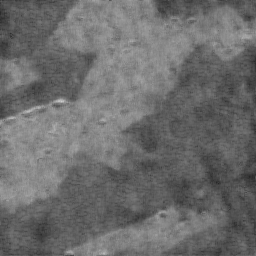

In [ ]:
gray_images[78]

# **Implementing Colorization Model**

In [ ]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt



## Preparing dataset for colorization model

In [ ]:
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

def rgb_to_lab(img):

    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)
    L_channel = img_lab[[0], ...]
    ab_channels = img_lab[[1, 2], ...]
    # scale between -1 to 1
    L_channel = 2 * (L_channel - (0)) / (100 - (0)) - 1
    ab_channels = 2 * (ab_channels - (-128)) / (127 - (-128)) - 1

    return L_channel, ab_channels

In [ ]:
def create_patches(img, patch_size=224):
    patches = []
    h, w = img.shape[1:]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)

    return patches

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None, patch_size=224):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.grayscale_dir)

    def __getitem__(self, idx):

        gray_img = self.grayscale_dir[idx]
        color_img = np.array(Image.open(self.color_dir[idx]))

        # resize image to 224
        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        # Convert to Lab color space
        gray_L, gray_ab = rgb_to_lab(cv2.merge((gray_img, gray_img, gray_img)))
        L_channel, ab_channels = rgb_to_lab(color_img)

        # # convert gray in range of -1 to 1
        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)


        return gray_L, ab_channels


In [ ]:
dataset = ColorizationDataset(gray_images[:10000], opt[:10000])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)




In [ ]:
# Load a batch and print the shapes of the patches
for L_patches, ab_patches in train_loader:
    print(f"L_patches shape: {L_patches.shape}")
    print(f"ab_patches shape: {ab_patches.shape}")
    print(L_patches[0])
    break

L_patches shape: torch.Size([32, 1, 224, 224])
ab_patches shape: torch.Size([32, 2, 224, 224])
tensor([[[-0.2784, -0.3020, -0.4980,  ..., -0.2706, -0.2235, -0.1451],
         [-0.4039, -0.3882, -0.4431,  ..., -0.2471, -0.2314, -0.2000],
         [-0.4196, -0.4196, -0.4275,  ..., -0.1922, -0.1922, -0.2235],
         ...,
         [-0.1373, -0.1059, -0.1608,  ..., -0.4275, -0.3882, -0.2471],
         [-0.1137, -0.0745, -0.1373,  ..., -0.4431, -0.4196, -0.3804],
         [-0.0431, -0.1137, -0.1373,  ..., -0.4118, -0.4275, -0.2392]]])


## Implementing the Encoder

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, DenseNet121_Weights

class EnsembleEncoder(nn.Module):
    def __init__(self):
        super(EnsembleEncoder, self).__init__()

        # Load pre-trained ResNet50 and DenseNet121
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # self.densenet121 = nn.Sequential(*list(self.densenet121.children())[:-1])
        self.densenet121.classifier = nn.Identity()


        # Custom layers for fusion
        self.conv1x1_resnet50 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(2048, 1024, kernel_size=1)
        ])

        self.conv1x1_densenet121 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(1024, 1024, kernel_size=1)
        ])

        self.fusion_blocks = nn.ModuleList([
            self.fusion_block(128, 128),
            self.fusion_block(256, 256),
            self.fusion_block(512, 512),
            self.fusion_block(1024, 1024)
        ])

    # Fusion block
    def fusion_block(self, in_channels_resnet, in_channels_densenet):
        return nn.Sequential(
            nn.Conv2d(in_channels_resnet + in_channels_densenet, in_channels_resnet, kernel_size=1),
            nn.BatchNorm2d(in_channels_resnet),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through ResNet50
        resnet_features = []
        resnet_input = x
        for i, layer in enumerate(self.resnet50.children()):
            resnet_input = layer(resnet_input)
            if i in [4, 5, 6, 7]:  # Extract features after specific layers
                resnet_features.append(self.conv1x1_resnet50[i-4](resnet_input))

        # Forward pass through DenseNet121
        densenet_features = []
        idx = 0
        densenet_input = x
        for i, layer in enumerate(self.densenet121.features):
            densenet_input = layer(densenet_input)
            if i in [ 4, 6, 8, 11]:
                densenet_features.append(self.conv1x1_densenet121[idx](densenet_input))
                idx += 1


        fused_features = []
        for i in range(4):
            fused = torch.cat((resnet_features[i], densenet_features[i]), dim=1)
            fused = self.fusion_blocks[i](fused)
            fused_features.append(fused)

        return fused_features


## Implementing the Decoder

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Decoder block 1: Takes input from Fusion Block 4
        self.decode1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 7x7 -> 14x14
        )

        # Decoder block 2: Takes input from Decoder Block 1 + Fusion Block 3 (512 + 512 channels)
        self.decode2 = nn.Sequential(
            nn.Conv2d(512 + 512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14 -> 28x28
        )

        # Decoder block 3: Takes input from Decoder Block 2 + Fusion Block 2 (256 + 256 channels)
        self.decode3 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28 -> 56x56
        )

        # Decoder block 4: Takes input from Decoder Block 3 + Fusion Block 1 (128 + 128 channels)
        self.decode4 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 56x56 -> 112x112
        )

        # Final decoder block: Reduce to 2 channels (ab channels)
        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 112x112 -> 224x224
        )

    def forward(self, features_7x7, features_14x14, features_28x28, features_56x56):
        x = self.decode1(features_7x7)
        x = torch.cat([x, features_14x14], dim=1)
        x = self.decode2(x)

        x = torch.cat([x, features_28x28], dim=1)
        x = self.decode3(x)

        x = torch.cat([x, features_56x56], dim=1)
        x = self.decode4(x)

        output = self.decode5(x)

        return output


## Checking our model

In [ ]:
import torch
import torch.nn as nn

class ColorizationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ColorizationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        features_56x56, features_28x28, features_14x14, features_7x7 = self.encoder(x)

        output = self.decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        return output

encoder = EnsembleEncoder()
decoder = Decoder()

model = ColorizationModel(encoder, decoder)

# input data
L_patches = torch.randn(1, 3, 224, 224)

output = model(L_patches)

print("Output shape:", output.shape)  # output shape should be [1, 2, 224, 224]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 196MB/s]


Output shape: torch.Size([1, 2, 224, 224])


## Training the model

In [ ]:
%%time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EnsembleEncoder()
decoder = Decoder()

# Freeze the encoder parameters as they are not to be trained
for param in encoder.parameters():
    param.requires_grad = False


model = ColorizationModel(encoder, decoder).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")

    for i, (L_batch, ab_batch) in enumerate(train_bar):
        L, ab = L_batch.to(device), ab_batch.to(device)
        L = L.repeat(1, 3, 1, 1)

        optimizer.zero_grad()

        output = model(L)

        loss = criterion(output, ab)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_bar.set_postfix(loss=f"{running_loss/(i+1):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

    with torch.no_grad():
        for i, (L_batch, ab_batch) in enumerate(val_bar):
            L, ab = L_batch.to(device), ab_batch.to(device)
            L = L.repeat(1, 3, 1, 1)

            output = model(L)
            loss = criterion(output, ab)
            val_loss += loss.item()

            val_bar.set_postfix(loss=f"{val_loss/(i+1):.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'best_colorization_model.pth')

print("Training complete.")

Epoch 1/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.25it/s, loss=0.0045]


Epoch 1/15, Training Loss: 0.0077, Validation Loss: 0.0045


Epoch 2/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, loss=0.0042]


Epoch 2/15, Training Loss: 0.0049, Validation Loss: 0.0042


Epoch 3/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.23it/s, loss=0.0041]


Epoch 3/15, Training Loss: 0.0046, Validation Loss: 0.0041


Epoch 4/15 (Validation): 100%|██████████| 50/50 [00:41<00:00,  1.19it/s, loss=0.0045]


Epoch 4/15, Training Loss: 0.0045, Validation Loss: 0.0045


Epoch 5/15 (Validation): 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss=0.0041]


Epoch 5/15, Training Loss: 0.0042, Validation Loss: 0.0041


Epoch 6/15 (Validation): 100%|██████████| 50/50 [00:41<00:00,  1.21it/s, loss=0.0040]


Epoch 6/15, Training Loss: 0.0041, Validation Loss: 0.0040


Epoch 7/15 (Validation): 100%|██████████| 50/50 [00:41<00:00,  1.21it/s, loss=0.0038]


Epoch 7/15, Training Loss: 0.0039, Validation Loss: 0.0038


Epoch 8/15 (Validation): 100%|██████████| 50/50 [00:41<00:00,  1.21it/s, loss=0.0039]


Epoch 8/15, Training Loss: 0.0040, Validation Loss: 0.0039


Epoch 9/15 (Validation): 100%|██████████| 50/50 [00:41<00:00,  1.20it/s, loss=0.0038]


Epoch 9/15, Training Loss: 0.0037, Validation Loss: 0.0038


Epoch 10/15 (Validation): 100%|██████████| 50/50 [00:39<00:00,  1.26it/s, loss=0.0037]


Epoch 10/15, Training Loss: 0.0035, Validation Loss: 0.0037


Epoch 11/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, loss=0.0036]


Epoch 11/15, Training Loss: 0.0034, Validation Loss: 0.0036


Epoch 12/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.25it/s, loss=0.0036]


Epoch 12/15, Training Loss: 0.0033, Validation Loss: 0.0036


Epoch 13/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, loss=0.0038]


Epoch 13/15, Training Loss: 0.0032, Validation Loss: 0.0038


Epoch 14/15 (Validation): 100%|██████████| 50/50 [00:40<00:00,  1.23it/s, loss=0.0036]


Epoch 14/15, Training Loss: 0.0031, Validation Loss: 0.0036


Epoch 15/15 (Validation): 100%|██████████| 50/50 [00:39<00:00,  1.25it/s, loss=0.0037]

Epoch 15/15, Training Loss: 0.0032, Validation Loss: 0.0037
Training complete.
CPU times: user 10min 56s, sys: 43.3 s, total: 11min 40s
Wall time: 51min 28s


In [ ]:
torch.cuda.empty_cache()

## Preparing for prediction

In [ ]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab

class ColorizationDatasetNew(Dataset):
    def __init__(self, gray_img, opt_image, transform=None):
        self.gray_image = gray_img
        self.opt_image = opt_image
        self.transform = transform

    def __len__(self):
        return len(self.gray_image)

    def __getitem__(self, idx):
        gray_img = self.gray_image[idx]
        color_img = np.array(Image.open(self.opt_image[idx]))

        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        gray_L, gray_ab = rgb_to_lab(cv2.merge([gray_img, gray_img, gray_img]))
        L_channel, ab_channels = rgb_to_lab(color_img)

        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)

        return gray_L, L_channel, ab_channels

# Create the test dataset for prediction
dataset_new = ColorizationDatasetNew(gray_images, opt)

test_set_new = DataLoader(dataset_new, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
for L,real_L, ab in test_set_new:
    print(real_L.shape)
    print(L.shape)
    print(ab.shape)
    print(L[0][0])
    break

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])
tensor([[-0.0874,  0.0952,  0.1418,  ..., -0.1443, -0.0794,  0.0560],
        [ 0.2034,  0.2034,  0.1650,  ..., -0.0713, -0.0472,  0.0717],
        [ 0.2188,  0.1650,  0.1263,  ..., -0.0632, -0.0392,  0.0717],
        ...,
        [-0.2603, -0.2102, -0.1771,  ...,  0.0560,  0.1108,  0.0324],
        [-0.2771, -0.2185, -0.2102,  ...,  0.0007,  0.0481, -0.0713],
        [-0.2019, -0.2352, -0.3194,  ...,  0.0007,  0.0324, -0.2185]])


In [ ]:
# Get a batch from the test loader
dataiter = iter(test_set_new)
L_batch,real_L, ab_batch = next(dataiter)
L_batch, real_L, ab_batch = L_batch.to(device),real_L.to(device), ab_batch.to(device)
L_batch = L_batch.repeat(1, 3, 1, 1)

model.eval()
with torch.no_grad():
    predicted_ab = model(L_batch)


In [ ]:
predicted_ab[0][0]

tensor([[ 0.0156,  0.0127,  0.0068,  ...,  0.0314,  0.0276,  0.0257],
        [ 0.0135,  0.0114,  0.0073,  ...,  0.0253,  0.0246,  0.0243],
        [ 0.0094,  0.0090,  0.0083,  ...,  0.0131,  0.0187,  0.0216],
        ...,
        [-0.0382, -0.0432, -0.0530,  ..., -0.0621, -0.0587, -0.0570],
        [-0.0385, -0.0411, -0.0464,  ..., -0.0547, -0.0536, -0.0530],
        [-0.0386, -0.0401, -0.0431,  ..., -0.0510, -0.0510, -0.0511]],
       device='cuda:0')

In [ ]:
L_batch = L_batch[:, 0, :, :]
L_batch = L_batch.unsqueeze(1)

L_batch = (L_batch + 1) * 0.5 * 100
real_L = (real_L + 1) * 0.5 * 100
predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

# Combine L and ab channels
predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
real_lab = torch.cat([L_batch, ab_batch], dim=1)
actual_lab = torch.cat([real_L, ab_batch], dim=1)

predicted_lab = predicted_lab.cpu().numpy()
real_lab = real_lab.cpu().numpy()
actual_lab = actual_lab.cpu().numpy()

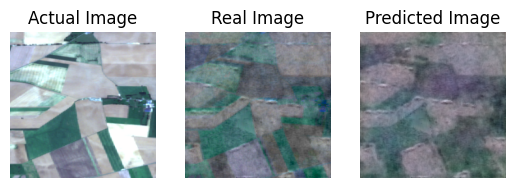

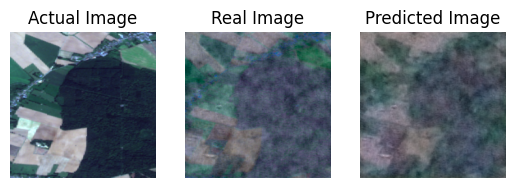

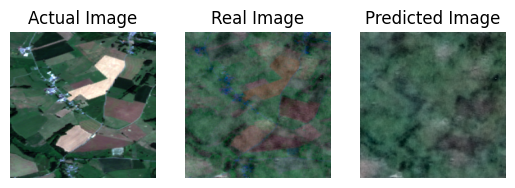

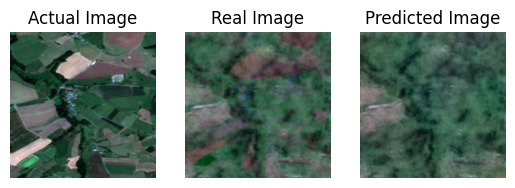

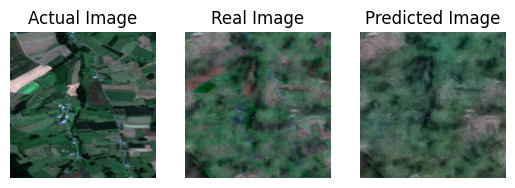

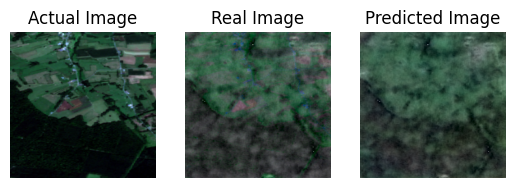

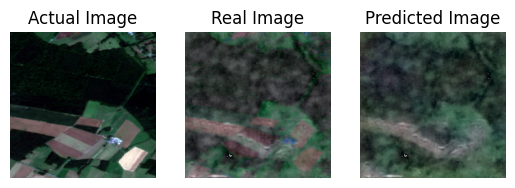

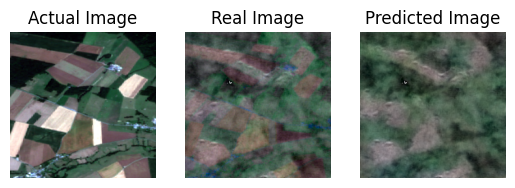

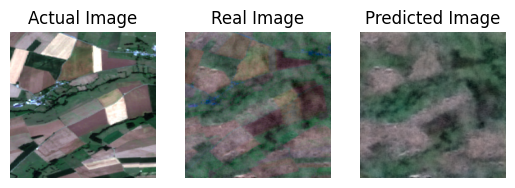

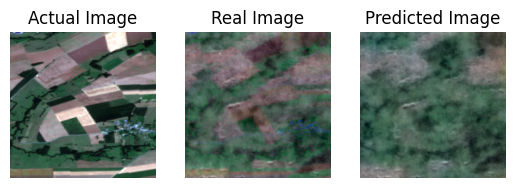

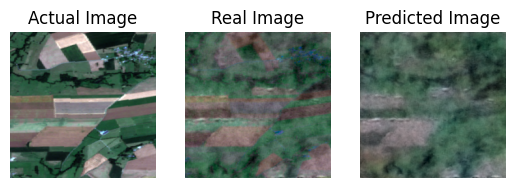

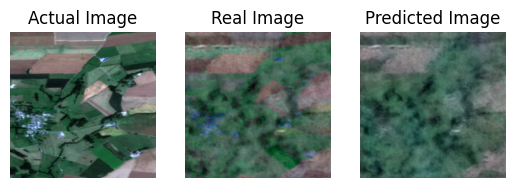

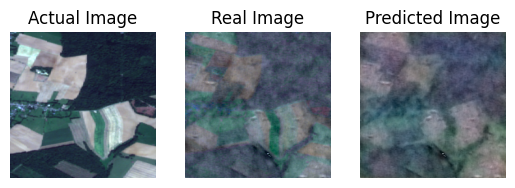

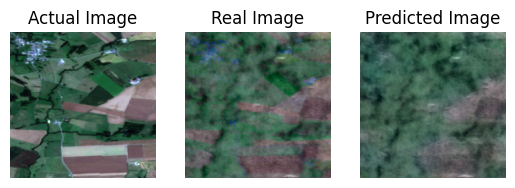

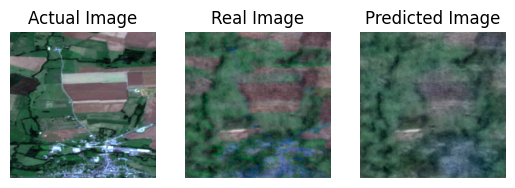

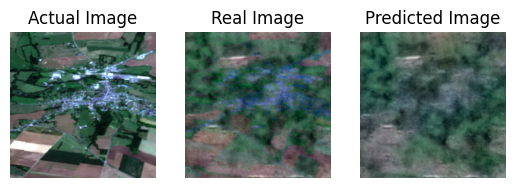

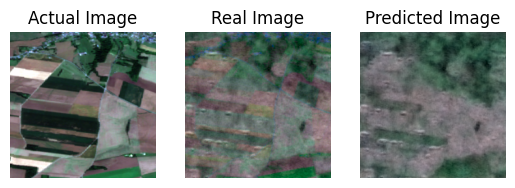

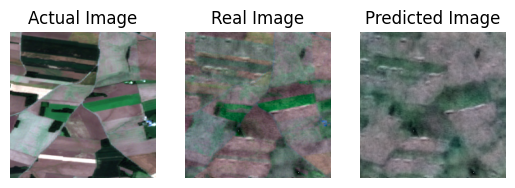

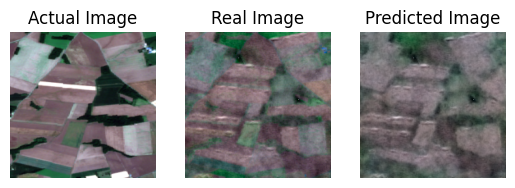

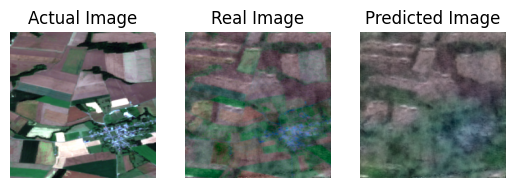

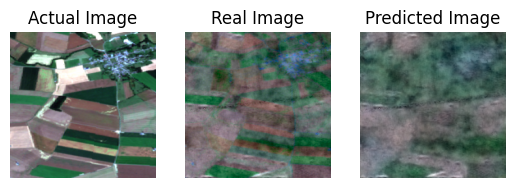

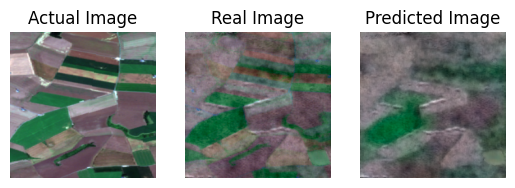

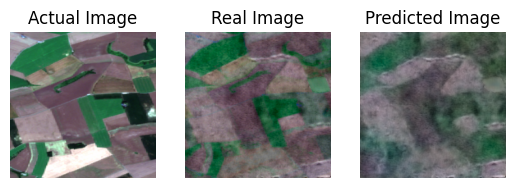

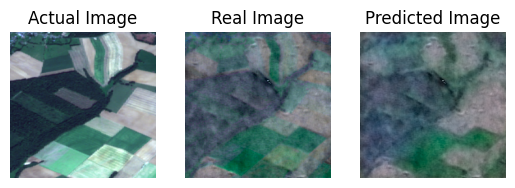

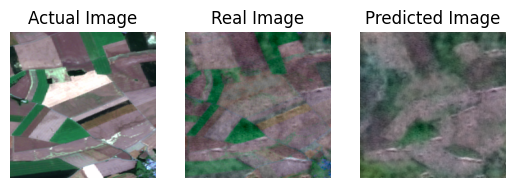

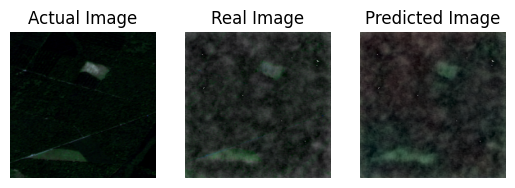

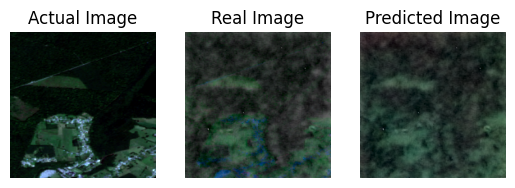

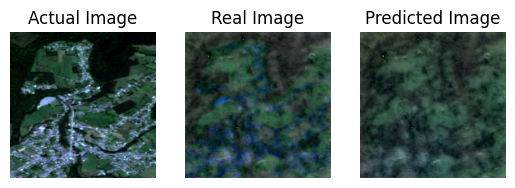

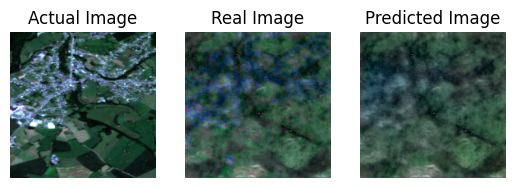

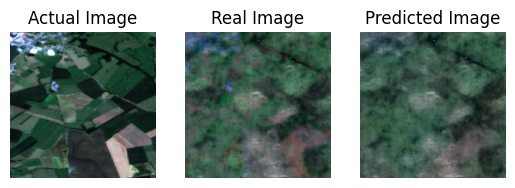

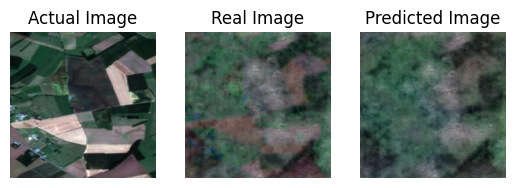

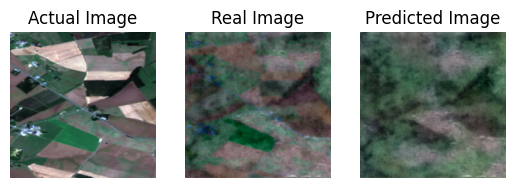

In [ ]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import cv2

# Iterate over the batch
for i in range(32):

    lab_image = predicted_lab[i]
    real_img = real_lab[i]
    actual_img = actual_lab[i]

    # Transpose to (height, width, 3) for skimage
    lab_image = lab_image.transpose(1, 2, 0)
    real_img = real_img.transpose(1, 2, 0)
    actual_img = actual_img.transpose(1, 2, 0)

    # Convert Lab to RGB using skimage.color.lab2rgb
    rgb_image = lab2rgb(lab_image)
    real_rgb = lab2rgb(real_img)
    actual_rgb = lab2rgb(actual_img)

    plt.subplot(1, 3, 1)
    plt.imshow(actual_rgb)
    plt.axis('off')
    plt.title('Actual Image')
    plt.subplot(1, 3, 2)
    plt.imshow(real_rgb)
    plt.axis('off')
    plt.title('Real Image')
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_image)
    plt.title('Predicted Image')
    plt.axis('off')
    plt.show()

## Evaulting the Model

In [ ]:
# TODO : Evaluation